# Logistic Regression and Naive Bayes over Count Vectorizer

# Best scores obtained with single models:


# LB
```python
n_words = 5000
top_n_words = [w for w, c in V.most_common(n_words)]
top_n_words
vect_top_n = TfidfVectorizer(vocabulary=top_n_words)
m = LogisticRegression()
m, df_feature_train = count_vect_pipeline_v2(df_train, df_val, df_test, vect_top_n, m, f'logistic_over_{n_words}_top_words_tfidf')

```

```
Train accuracy: 0.870
Val accuracy  : 0.795 (CV)
Leaderboard   : 0.78976 (LB)
```

# CV

```python
n_words = 5000
top_n_words = [w for w, c in V.most_common(n_words)]
top_n_words
vect_top_n = CountVectorizer(vocabulary=top_n_words)
m = LogisticRegression()
m, df_feature_train = count_vect_pipeline_v2(df_train, df_val, df_test, vect_top_n, m, f'logistic_over_{n_words}_top_words')

```

```
Train accuracy: 0.921
Val accuracy  : 0.776
Leaderboard   : 0.79190 (LB)
```


In [1]:
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter


def flatten(t):
    return [item for sublist in t for item in sublist]

def load_dfs(test_size=0.1, shuffle=False, verbose=True):
    df = pd.read_csv("data/train.csv")
    df = df.drop(['keyword', 'location'], axis=1)
    
    df_test = pd.read_csv("data/test.csv")
    df_test = df_test.drop(['keyword', 'location'], axis=1)
    
    df_sub = pd.read_csv("data/sample_submission.csv")
    
    df_train, df_val = train_test_split(df, test_size=test_size, shuffle=shuffle)

    if verbose:
        print(f"train shape: {df_train.shape}")
        print(f"val shape  : {df_val.shape}")
        print(f"test shape : {df_test.shape}")
    return df_train, df_val, df_test, df_sub


def get_vocab(df, drop_stopwords=True, keep_only_alpha=True):
    l = flatten(df['text'].str.lower().str.split().tolist())
    if drop_stopwords:
        st = stopwords.words('english')
        l = [w for w in l if w not in st and (not keep_only_alpha or w.isalpha())]
    return Counter(l)


In [2]:
df_train, df_val, df_test, df_sub = load_dfs()

train shape: (6851, 3)
val shape  : (762, 3)
test shape : (3263, 2)


In [24]:
#!pip install xgboost
#!pip install lightgbm
#!pip install catboost

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
import warnings; warnings.simplefilter('ignore')

In [20]:
def run(model, df_train, df_val):
    model.fit(df_train['text'], df_train['target'])
    y_pred_train = model.predict(df_train['text'])
    y_pred_val = model.predict(df_val['text'])
    
    train_acc = accuracy_score(df_train['target'], y_pred_train)
    val_acc = accuracy_score(df_val['target'], y_pred_val)
    return model, train_acc, val_acc


def run_models(models, df_train, df_val):
    res = []
    trained_models = []
    for name, model in models:
        model, train_acc, val_acc = run(model, df_train, df_val)
        res.append((name, train_acc, val_acc))
        trained_models.append((name, model))

    df_res = pd.DataFrame(res, columns=['model', 'train acc', 'val acc']).sort_values("val acc", ascending=False)
    display(df_res)
    return df_res, trained_models

In [22]:
tree_and_ensemble_models = [
    ('dt', Pipeline([('vect', TfidfVectorizer(max_features=2000)), ('model', DecisionTreeClassifier())])),
    ('lgb', Pipeline([('vect', TfidfVectorizer(max_features=3000)), ('model', LGBMClassifier(n_estimators=1000))])),
    ('xgb', Pipeline([('vect', TfidfVectorizer(max_features=3000)), ('model', XGBClassifier(n_estimators=1000))])),
    ('catb', Pipeline([('vect', TfidfVectorizer(max_features=3000)), ('model', CatBoostClassifier(n_estimators=1000, verbose=0))])),
    ('rf', Pipeline([('vect', TfidfVectorizer(max_features=3000)), ('model', RandomForestClassifier(n_estimators=1000))])),
]

df_res, trained_models = run_models(tree_and_ensemble_models, df_train, df_val)

/home/dataista/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


,model,train acc,val acc
4,rf,0.983506,0.769029
2,xgb,0.978251,0.758530
3,catb,0.860166,0.758530
1,lgb,0.981025,0.745407
0,dt,0.983068,0.678478


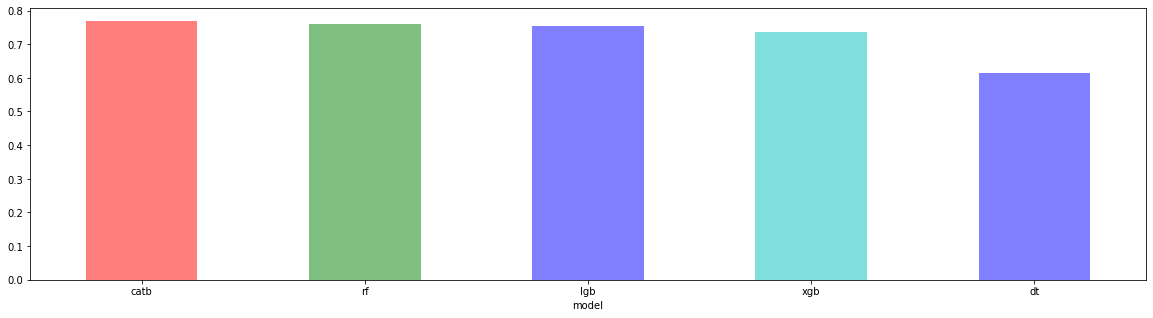

In [16]:
df_res.set_index('model')['val acc'].plot.bar(figsize=(20, 5), 
                                              alpha=0.5, 
                                              color=['r', 'g', 'b', 'c', 'b'],
                                              rot=0)